# <center>ASTR4004/8004 - Simulations - Part 1</center>

This notebook builds a simple collisionless N-body simulation, based on the following pseudocode:

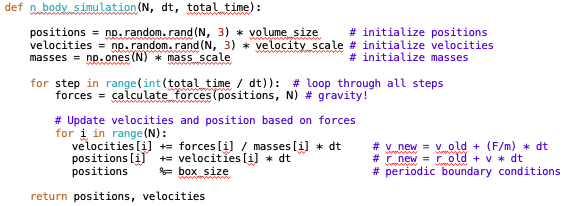


## Useful packages

In [1]:
import matplotlib
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## gravity

$$
\vec{a}_{i} = - G \sum \limits_{j\neq i} m_{j} \frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_{j}-\vec{r}_{i}|^{3} }
$$
Here, $m$, $\vec{r}$ and $\vec{a}$ are the mass, position and accelaration of the particle while G is the gravitational constant.

In [2]:
def calculate_forces( pos, mass, G, softening ):
    
    # Position is in shape of (N,3)
    # mass is in shape of (N,1)
    # return accelaration in shape of (N,3)
    
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    # Here we introduce softening length to avoid r = 0
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)**-1.5

    # Avoid self-interaction
    np.fill_diagonal(inv_r3, 0) 

    # Calculate the accelerations
    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass
	
    # pack together the acceleration components
    a = np.hstack((ax,ay,az))
    
    return a

In [3]:
def calculate_forces( pos, mass, G, softening ):
    # Calculate pairwise separations and avoid self-interaction
    dist = pos[:, None] - pos
    dist_squared = np.sum(dist ** 2, axis=2) + softening**2
    inv_r3 = dist_squared ** -1.5
    np.fill_diagonal(inv_r3, 0)

    # Compute accelerations
    return -G *  (np.swapaxes(dist * inv_r3[:,:,None],1,2) @ mass).squeeze()

## Potential and Kinetic Energy

In an ideal N-body simulation, the total mechanical energy (the sum of kinetic and potential energy) should remain constant over time if the system is closed and no external forces act on it. By tracking these energy components, you can identify whether the simulation is behaving as expected. Significant fluctuations in total energy might indicate numerical errors, inaccuracies in the force calculations (e.g. softening length), or insufficient time-stepping

$$
KE_{i} = 0.5 m_{i} \vec{v}_{i}^2,
$$
$$
PE_{i} = - G \sum \limits_{j\neq i} \frac{m_{j} m_{i}} {|\vec{r}_{j}-\vec{r}_{i}|},
$$
where, $\vec{v}$ is the velocity of the particle.

In [4]:
def calculate_energy( pos, vel, mass, G, softening ):
	# Kinetic Energy:
	KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


	# Potential Energy:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations 
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
	
	return KE, PE;

In [5]:
def calculate_energy( pos, vel, mass, G, softening ):
    
    # Kinetic Energy:
    KE = 0.5 * np.sum(np.sum( mass * vel**2 ))
    
    # Calculate pairwise separations and avoid self-interaction
    dist = pos[:, None] - pos
    dist_squared = np.sum(dist ** 2, axis=2) + softening**2
    inv_r = dist_squared ** -0.5
    
    np.fill_diagonal(inv_r, 0)
    # sum over upper triangle, to count each interaction only once
    PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r)))
    
    return KE, PE

## Half-kick and drift

In N-body simulations, the half-kick and drift technique is commonly used to achieve a more accurate integration of the equations of motion. 

* Initial kick (Half-Kick):
    * Initially, update the velocities of the particles using the forces acting on them. This is a half-step update, where you only partially update the velocities based on the current acceleration.
    * The formula for the half-kick is: $$ \vec{v}_{i}(t+\Delta t/2) = \vec{v}_{i}(t) + \vec{a}_{i}(t) \Delta t/2 $$
    * Here, $t$ and $\Delta t$ are the current time and time step.
* Drift:
    * Update the positions of the particles using the half-kicked velocities.
    * The position update is given by: $$\vec{r}_{i}(t+\Delta t) = \vec{r}_{i}(t) + \vec{v}_{i}(t+\Delta t/2) \Delta t$$
    * This uses the velocities that have already been half-updated.
* Final (half) kick:
    * Finally, update the velocities again with the new accelerations calculated from the new positions.
    * This is the second half-kick: $$ \vec{v}_{i}(t+\Delta t) = \vec{v}_{i}(t+\Delta t/2) + \vec{a}_{i}(t+\Delta t) \Delta t/2 $$

Benefits of Half-Kick and Drift

* Energy Conservation: This method conserves energy better than simple Euler method over long time integrations.
* Stability: The scheme is more stable for long-term simulations of gravitational dynamics, reducing the drift of energy that can accumulate in naive integration schemes.

Read more about Leapfrog integration

In [6]:
# Simulation parameters
dt         = 0.01    # timestep
softening  = 0.01    # softening length
G          = 1.0     # Newton's Gravitational Constant

# nbody takes mass and initial position and velocity as inputs
def nbody(mass, pos0, vel0):
    
    # declare position, velocity, accelaration and time are global variables
    global pos, vel, acc, t

    pos = pos0
    vel = vel0
    t = 0      # current time of the simulation
    
    # Convert to Center-of-Mass frame
    vel -= np.mean(mass * vel,0) / np.mean(mass)
    
    # calculate initial gravitational accelerations
    acc = calculate_forces( pos, mass, G, softening )
    
    # calculate initial energy of system
    KE, PE  = calculate_energy( pos, vel, mass, G, softening )

    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,10), gridspec_kw={'height_ratios': [2, 1]})
    
    ax1.set(xlim=(pmin, pmax), ylim=(pmin, pmax))
    ax1.set_aspect('equal', 'box')

    energy_scale = max(KE, -PE) * 1.5
    ax2.set(xlim=(0, Nframe*dt), ylim=(-energy_scale,energy_scale))
    ax2.set_xlabel('time')
    ax2.set_ylabel('energy')

    # Initialize scatter plot for positions
    scat = ax1.scatter(pos[:,0],pos[:,1],s=mass*10,color='k')

    # Initialize quiver plot for velocities
    quiv = ax1.quiver(pos[:, 0], pos[:, 1], vel[:, 0], vel[:, 1],
                     color='red', scale=50, width=0.002)
    
    ke_data   = [KE, ]
    pe_data   = [PE, ]
    te_data   = [KE+PE, ]
    time_data = [t, ]

    ke_plot, = ax2.plot(time_data,ke_data,color='red',label='KE')
    pe_plot, = ax2.plot(time_data,pe_data,color='blue',label='PE')
    te_plot, = ax2.plot(time_data,te_data,color='k',label='PE+KE')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    
    def evolve(it):
        global pos, vel, acc, t
        
        # (1/2) kick
        vel += acc * dt/2.0
        
        # drift
        pos += vel * dt
        
        # update accelerations
        acc = calculate_forces( pos, mass, G, softening )
        
        # (1/2) kick
        vel += acc * dt/2.0
        
        # update time
        t += dt
        
        # get energy of system
        KE, PE  = calculate_energy( pos, vel, mass, G, softening )
        
        # Update the scatter plot
        scat.set_offsets(pos[:, :2])

        # Update quiver plot for new velocities
        quiv.set_offsets(pos[:, 0:2])
        quiv.set_UVC(vel[:, 0], vel[:, 1])  # Update velocity vectors
        
        # Update energy data for plotting
        time_data.append(t)
        ke_data.append(KE)
        pe_data.append(PE)
        te_data.append(PE+KE)
        
        ke_plot.set_data(time_data, ke_data)
        pe_plot.set_data(time_data, pe_data)
        te_plot.set_data(time_data, te_data)
    
    anim = FuncAnimation(
        fig,
        evolve,
        frames = Nframe,
        interval = interval,
        blit = True,
        repeat = False,
    )
   
    return anim

### Let's do some close encouters
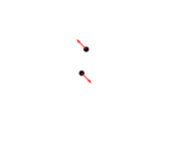

fix location, increase mass or decrease velocity to see the difference

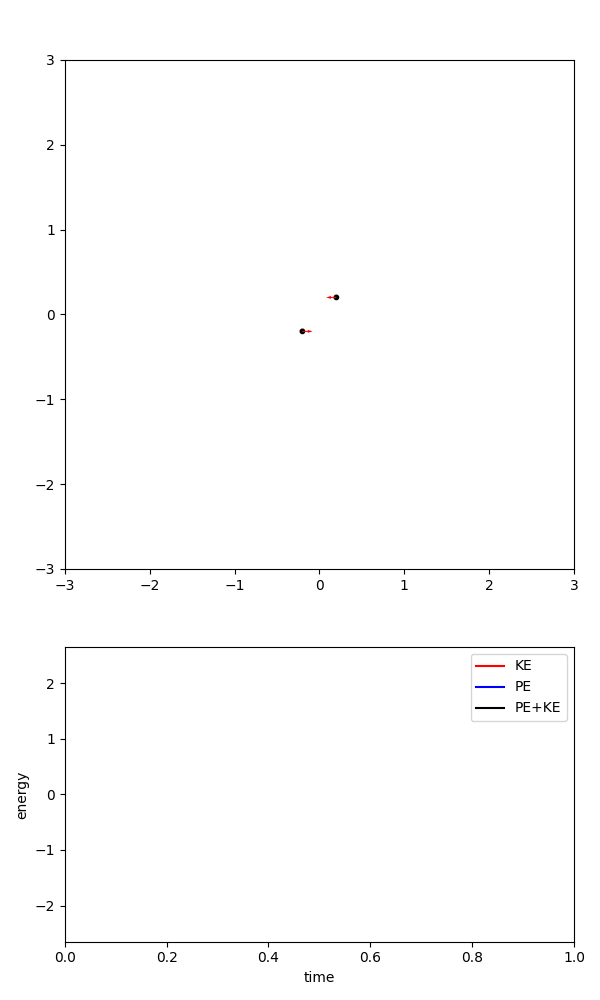

In [7]:
plt.close()
Nframe     = 100    # number of simulation steps
pmin, pmax = -3, 3   # box range
interval   = 10      # delay between movie frames in milliseconds 

# Generate Initial Conditions
mass0 = np.array([1,1], dtype='float').reshape([2,1])
pos0 = np.array([[-1,-1,0],[1,1,0]], dtype='float') * 0.2
vel0 = np.array([[1,0,0],[-1,0,0]], dtype='float')

anim = nbody(mass0,pos0,vel0)

### Let's do some circular orbits

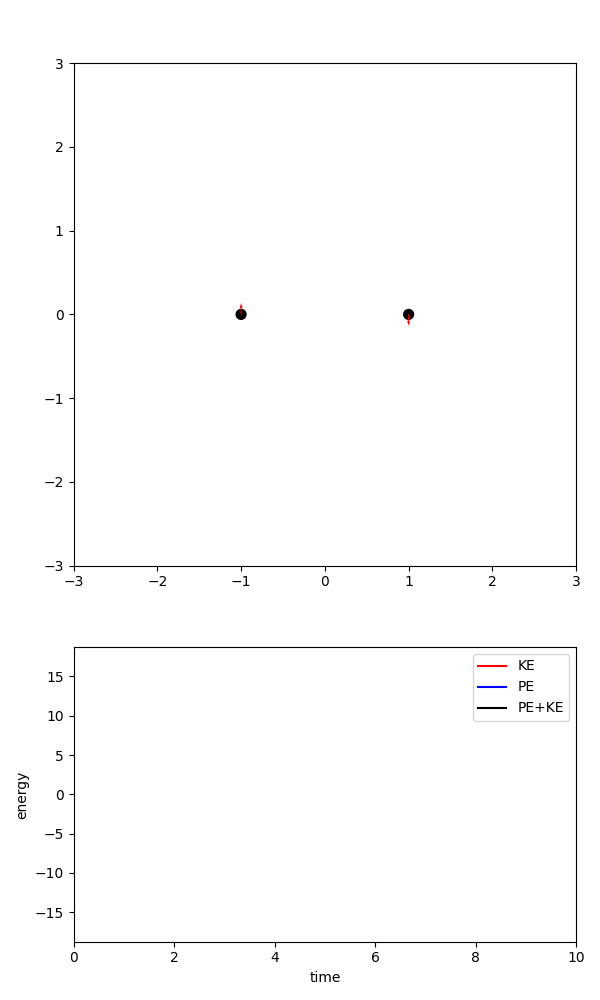

In [18]:
plt.close()
Nframe     = 1000    # number of simulation steps
pmin, pmax = -3, 3   # box range
interval   = 1      # delay between movie frames in milliseconds 

# Generate Initial Conditions
mass0 = np.array([5,5], dtype='float').reshape([2,1])
pos0 = np.array([[-1,0,0],[1,0,0]], dtype='float')
vel0 = np.array([[0,1,0],[0,-1,0]], dtype='float')*1.12

anim = nbody(mass0,pos0,vel0)

## planets circulating Sun
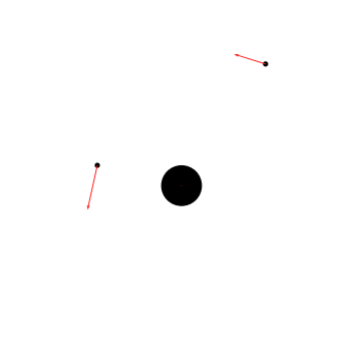

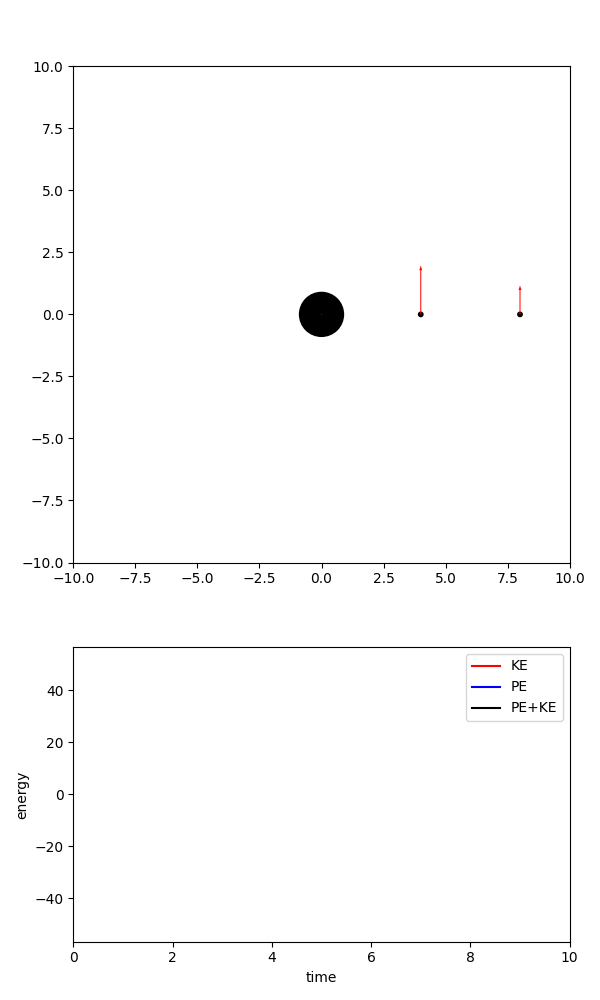

In [22]:
plt.close()
Nframe     = 1000    # number of simulation steps
pmin, pmax = -10, 10   # box range
interval   = 3      # delay between movie frames in milliseconds 


mass0 = np.array([100,1,1], dtype='float').reshape([-1,1])
pos0 = np.array([[0,0,0],[4,0,0],[8,0,0]], dtype='float')
vel0 = np.array([[0,0,0],[0,5,0],[0,3,0]], dtype='float')

anim = nbody(mass0,pos0,vel0)

## let's add a moon

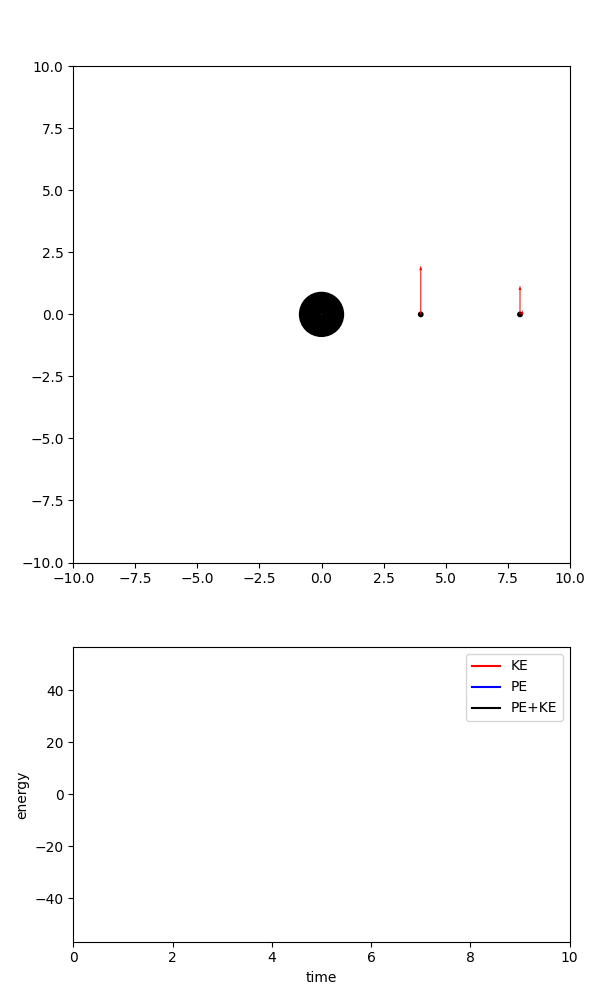

In [23]:
plt.close()
Nframe     = 1000    # number of simulation steps
pmin, pmax = -10, 10   # box range
interval   = 3      # delay between movie frames in milliseconds 


mass0 = np.array([100,1,1,0.001], dtype='float').reshape([-1,1])
pos0 = np.array([[0,0,0],[4,0,0],[8,0,0],[8.1,0,0]], dtype='float')
vel0 = np.array([[0,0,0],[0,5,0],[0,3,0],[0,0.5,0]], dtype='float')


anim = nbody(mass0,pos0,vel0)

## a stellar cluster
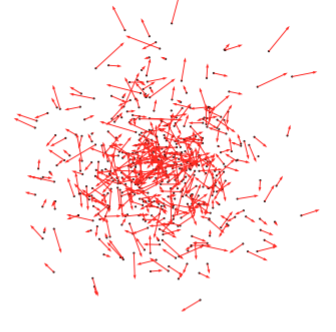

try setting the system in virilized state, i.e. 2KE+PE = 0

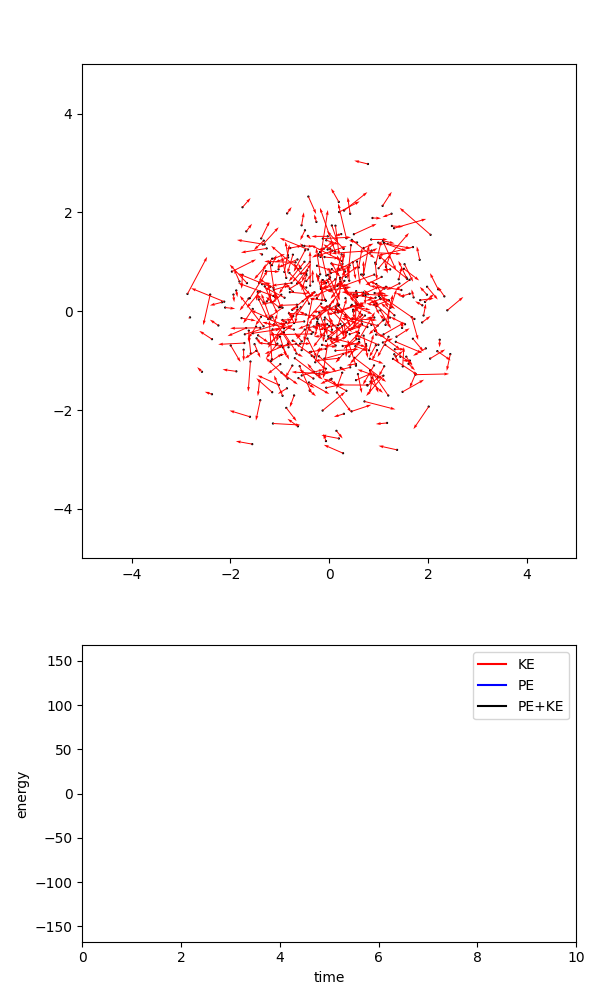

In [24]:
plt.close()
Nframe     = 1000    # number of simulation steps
pmin, pmax = -5, 5   # box range
interval   = 1      # delay between movie frames in milliseconds 

np.random.seed(24)            # set the random number generator seed
N = 500
mass0 = 20*np.ones((N,1))/N  # total mass of particles is 20
pos0  = np.random.randn(N,3)   # randomly selected positions and velocities
vel0  = np.random.randn(N,3)*1.5

anim = nbody(mass0,pos0,vel0)

## two clusters merging
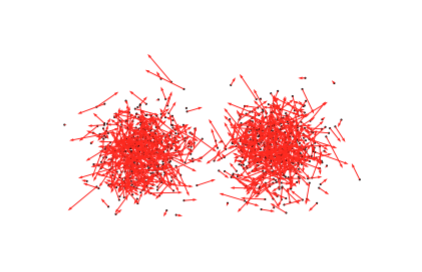


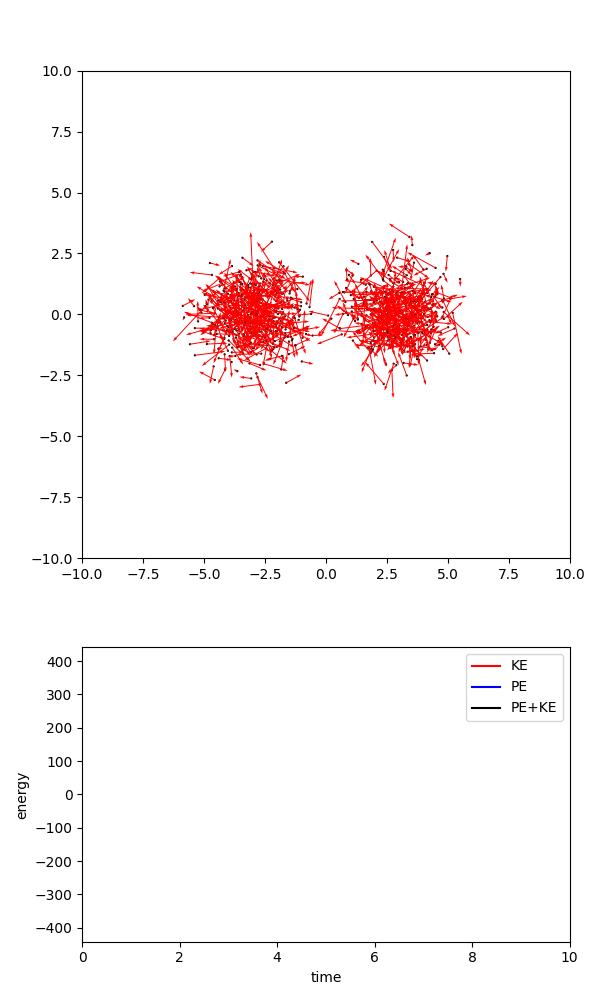

In [26]:
plt.close()
Nframe     = 1000    # number of simulation steps
pmin, pmax = -10, 10   # box range
interval   = 1      # delay between movie frames in milliseconds 

np.random.seed(24)            # set the random number generator seed
N = 1000
mass0 = 40*np.ones((N,1))/N  # total mass of particles is 40
pos1  = np.random.randn(N//2,3)   # randomly selected positions and velocities
pos2  = np.random.randn(N//2,3)   # randomly selected positions and velocities
pos1[:,0]-= 3
pos2[:,0]+= 3
pos0  = np.concatenate([pos1,pos2])   # randomly selected positions and velocities
vel0  = np.random.randn(N,3)*1.5

anim = nbody(mass0,pos0,vel0)